In [1]:
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from IPython.display import display_html

In [2]:
from mlxtend.plotting import plot_decision_regions
from scipy import stats

import math

from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

#KNeighborsClassifier
#LogisticRegressionClassifier
#RandomForestClassifier

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [4]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=20):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(20)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def na_summary(df, group_col, additional_cols=None):
    if additional_cols is None:
        additional_cols = ["log_saleprice"]

    additional_cols.append(group_col)
    # fmt: off
    df = (
      df[additional_cols]
        .fillna("NaN")
        .groupby(group_col)
        .agg(["size", "mean", "sum"])
    )
    display(df)
    # fmt: on


In [5]:
df = pd.read_csv('noshowappointments.csv')

Data Dictionary - The goal is to predict whether a given patient will not show up to their appointment. 

PatientId -Identification of a patient

AppointmentID - Identification of each appointment

Gender - Male or Female

AppointmentDay - The day of the actual appointment, when they have to visit the doctor

ScheduledDay - The day someone called or registered the appointment, this is before appointment of course.

Age - Age of the patient.

Neighborhood - Where the appointment takes place.

Scholarship - True of False. Whether or not the school age patient is participating in Bolsa Famila which pays a stipend based on meeting certain metrics like class attendance or getting vaccinated. 
https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

Hypertension - True or False

Diabetes -True or False

Alcoholism - True or False

Disability - 0-4. 0 is no disability and remaining numbers indicate how many disabilities the patient has

Reminder - True or False. 1 or more messages sent to the patient

No-show - True or False

In [6]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [7]:
df.shape

(110527, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [9]:
df['AppointmentID'].value_counts(bins=20)

(5638433.2, 5676445.9]      25948
(5676445.9, 5714458.6]      24404
(5714458.6, 5752471.3]      19104
(5752471.3, 5790484.0]      14735
(5600420.5, 5638433.2]      13031
(5562407.8, 5600420.5]       6335
(5524395.1, 5562407.8]       3513
(5486382.4, 5524395.1]       1270
(5410357.0, 5448369.7]       1083
(5448369.7, 5486382.4]        701
(5372344.3, 5410357.0]        162
(5334331.6, 5372344.3]         83
(5296318.9, 5334331.6]         48
(5106255.4, 5144268.1]         48
(5220293.5, 5258306.2]         24
(5258306.2, 5296318.9]         19
(5144268.1, 5182280.8]         13
(5182280.8, 5220293.5]          5
(5029469.745, 5068242.7]        1
(5068242.7, 5106255.4]          0
Name: AppointmentID, dtype: int64

In [10]:
#dropping and appointmentID

df = df.drop(columns = 'AppointmentID')

In [11]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [12]:
# cleaning column names

df['Neighborhood'] = df['Neighbourhood']
df = df.drop(columns=['Neighbourhood'])

df['Hypertension'] = df['Hipertension']
df = df.drop(columns=['Hipertension'])

df['Disability'] = df['Handcap']
df = df.drop(columns=['Handcap'])

df['Reminder'] = df['SMS_received']
df = df.drop(columns=['SMS_received'])

df['no_show'] = df['No-show']
df = df.drop(columns=['No-show'])

In [13]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,Disability,Reminder,no_show
0,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,0,0,JARDIM DA PENHA,1,0,0,No
1,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,JARDIM DA PENHA,0,0,0,No
2,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,MATA DA PRAIA,0,0,0,No
3,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,PONTAL DE CAMBURI,0,0,0,No
4,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,0,JARDIM DA PENHA,1,0,0,No


Converting to datetime data type.

In [14]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

In [15]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [16]:
# creating date variables from ScheduleDay

df["sch_hour"] = df["ScheduledDay"].dt.hour
df["sch_weekday_num"] = df["ScheduledDay"].dt.weekday
df["sch_weekday_name"] = df["ScheduledDay"].dt.day_name()

In [17]:
# creating date variables from AppointmentDay

df["app_hour"] = df["AppointmentDay"].dt.hour
df["app_weekday_num"] = df["AppointmentDay"].dt.weekday
df["app_weekday_name"] = df["AppointmentDay"].dt.day_name()
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,Disability,Reminder,no_show,sch_hour,sch_weekday_num,sch_weekday_name,app_hour,app_weekday_num,app_weekday_name
0,2.987250e+13,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,JARDIM DA PENHA,1,0,0,No,18,4,Friday,0,4,Friday
1,5.589978e+14,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,JARDIM DA PENHA,0,0,0,No,16,4,Friday,0,4,Friday
2,4.262962e+12,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,MATA DA PRAIA,0,0,0,No,16,4,Friday,0,4,Friday
3,8.679512e+11,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,PONTAL DE CAMBURI,0,0,0,No,17,4,Friday,0,4,Friday
4,8.841186e+12,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,0,JARDIM DA PENHA,1,0,0,No,16,4,Friday,0,4,Friday


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   PatientId         110527 non-null  float64            
 1   Gender            110527 non-null  object             
 2   ScheduledDay      110527 non-null  datetime64[ns, UTC]
 3   AppointmentDay    110527 non-null  datetime64[ns, UTC]
 4   Age               110527 non-null  int64              
 5   Scholarship       110527 non-null  int64              
 6   Diabetes          110527 non-null  int64              
 7   Alcoholism        110527 non-null  int64              
 8   Neighborhood      110527 non-null  object             
 9   Hypertension      110527 non-null  int64              
 10  Disability        110527 non-null  int64              
 11  Reminder          110527 non-null  int64              
 12  no_show           110527 non-null  object   

## Looking at target variable, no_show.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PatientId,110527.0,1.474963e+14,2.560949e+14,39217.84439,4.172614e+12,3.173184e+13,9.439172e+13,9.999816e+14
Age,110527.0,3.708887e+01,2.311020e+01,-1.00000,1.800000e+01,3.700000e+01,5.500000e+01,1.150000e+02
Scholarship,110527.0,9.826558e-02,2.976748e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Diabetes,110527.0,7.186479e-02,2.582651e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Alcoholism,110527.0,3.039981e-02,1.716856e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Hypertension,110527.0,1.972459e-01,3.979213e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Disability,110527.0,2.224796e-02,1.615427e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
Reminder,110527.0,3.210256e-01,4.668727e-01,0.00000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
sch_hour,110527.0,1.077452e+01,3.216189e+00,6.00000,8.000000e+00,1.000000e+01,1.300000e+01,2.100000e+01
sch_weekday_num,110527.0,1.851955e+00,1.378520e+00,0.00000,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00


In [20]:
df['no_show'].value_counts()

No     88208
Yes    22319
Name: no_show, dtype: int64

In [21]:
df.no_show.value_counts(normalize=True)

No     0.798067
Yes    0.201933
Name: no_show, dtype: float64

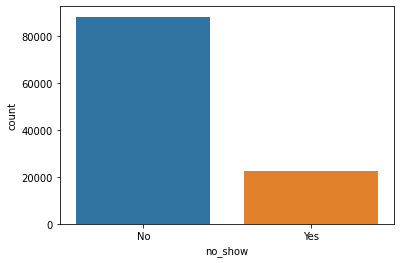

In [22]:
sns.countplot(x=df['no_show'])
plt.show()

In [ ]:
sns.scatterplot(x="test", y="project_grade", hue="is_pass", data=df)
plt.show()

In [23]:
df.describeAge.value_counts()

AttributeError: 'DataFrame' object has no attribute 'describeAge'

In [ ]:
df.Neighborhood.value_counts()

In [ ]:
df.Neighborhood.nunique()

In [ ]:
df.nunique()

In [ ]:
df.Disability.value_counts()

In [ ]:
df.describe(include='all',datetime_is_numeric=True).T

In [ ]:
print(df.PatientId.nunique())
df.PatientId.value_counts().head(20)

In [ ]:
df.shape